# Setup

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict

In [2]:
# default settings
class ReproductionArgs:
    def __init__(self):
        self.check_if_exists = False
        self.num_random_policies_to_test = 100
        self.augmentations_per_policy = 3
        self.num_possible_augmentations = 50
        
        self.aug_list = ''
        self.dataset_name = 'cifar100'
        self.data_path = './data'
        self.transform_mode = 'aug'
        self.normalize = True
        self.augment_validation = True
        self.architecture = 'ResNet20-4'
        self.model_trained_partially_path = '../models/tiny_data_cifar100_ResNet20-4_100epochs.pth'
        self.device = 'cuda'
        self.epochs = 100
        self.recon_tests_per_policy = 100
        self.num_images_per_recon_test = 1
        self.results_dir = './results'
        
        self.moment_range = 5
        
        self.attack_type = 'inversed'
        self.max_iters = 2500
        self.num_images_to_evaluate = 20
        self.optim = None
        self.rlabel = False
        self.resume = -1
        self.num_images = 1
        self.reaugment = 'none'
        self.samples = []
    
args = ReproductionArgs()

# Experiment \#1 Correlation

You may need to update ipython widgets for the torchvision download to work in jupyter notebook:

```pip install jupyter --upgrade```

```pip install ipywidgets --upgrade```

```jupyter nbextension enable --py widgetsnbextension```

(Kernel Restart after)

### Evaluate single datapoint

In [6]:
from correlation_test import CorrelationTest

""" settings for single test """
args.check_if_exists = False
args.num_random_policies_to_test = 1 # our test: 100, paper: 100
args.num_images_to_evaluate = 1 # our test: 20, paper: 100
args.recon_tests_per_policy = 1 # our test: 100, paper: 100
args.results_dir = './results_reproduction_notebook'

args.max_iters = 50 # our test: 2500, paper: 2500

# initiate tester
single_corr_tester = CorrelationTest(args)

# choose your favorite policy
policies_to_test = ['1-2-3']

# run test
single_corr_tester.perform_test(policies_to_test)

POLICY SEARCHER PROGRESS::   0%|                                                                 | 0/1 [00:00<?, ?it/s]

Currently evaluating -------------------------------:
Friday, 04. February 2022 05:34PM
CPUs: 12, GPUs: 1 on DESKTOP-0VPE5PG.
GPU : NVIDIA GeForce RTX 2070 SUPER
Files already downloaded and verified
Files already downloaded and verified
attack 0th in 1-2-3
ground truth label is  tensor([49], device='cuda:0')
It: 0. Rec. loss: 0.8677.
It: 49. Rec. loss: 0.6821.
Choosing optimal result ...
tensor([0.6820])
Optimal result score: 0.6820
Total time: 1.5680017471313477.
after optimization, the true mse loss 0.2394668459892273
> Evaluating privacy metrics for 1-2-3...


POLICY SEARCHER PROGRESS:: 100%|█████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/it]

Done! 1-2-3 scored 0.258 on average in reconstruction/area under curve metric
1-2-3 scored 0.25761246932666 & 6.207546234130859 db (evalled in 1.9189999103546143 seconds)
Saved privacy score in ./results_reproduction_notebook\correlation/data_cifar100_arch_ResNet20-4/1-2-3_privacy_score
Saved attack_PSNR in ./results_reproduction_notebook\correlation/data_cifar100_arch_ResNet20-4/1-2-3_attack_PSNR


### Evaluate all datapoints (commented to not run, takes 48h)

In [ ]:
# """ settings for single test """
# args.check_if_exists = True
# args.num_random_policies_to_test = 100 # our test: 100, paper: 100
# args.num_images_to_evaluate = 20 # our test: 20, paper: 100
# args.recon_tests_per_policy = 100 # our test: 100, paper: 100
# args.results_dir = './results'

# args.max_iters = 2500 # our test: 2500, paper: 2500

# # initiate tester
# tester = CorrelationTest(args)
# random_policies = tester.make_policy_list()

# # choose your favorite policy
# policies_to_test = ['1-2-3']

# # run test
# single_corr_tester.perform_test(random_policies)

### Plot Results

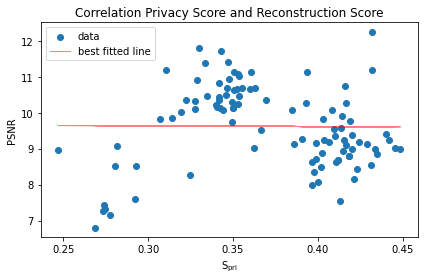

In [12]:
dataset = 'cifar100'
architecture = 'ResNet20-4'
results_folder = '../results'
folder_name = f"data_{dataset}_arch_{architecture}"
correlation_folder = results_folder+'/correlation/'+folder_name+'/'

scores = defaultdict(lambda: [0,0])
for i, filename in enumerate(os.listdir(correlation_folder)):
    # psnr scores
    if filename[-6:] == "NR.npy":
        scores[filename.split("_")[0]][0] = float(np.load(correlation_folder+filename))
        
    # privacy scores
    if filename[-6:] == "re.npy":
        scores[filename.split("_")[0]][1] = float(np.load(correlation_folder+filename))
        
fig, ax = plt.subplots()

psnrs = [a[0] for a in scores.values()]
privs = [a[1] for a in scores.values()]

ax.set_ylabel("PSNR")
ax.set_xlabel("$\mathregular{S_{pri}}$")

ax.set_xticks([0.25, 0.3, 0.35, 0.4, 0.45, 0.5])

ax.set_title("Correlation Privacy Score and Reconstruction Score")

ax.scatter(privs, psnrs, label='data')

m, b = np.polyfit(privs, psnrs, 1)
ax.plot(privs, m*np.array(privs) + b, color='red', linewidth=1, alpha=0.5, label='best fitted line')

plt.tight_layout()
plt.legend()
plt.show()

# Insight \#2: Uniqueness top policies